In [1]:
import pandas as pd
import matplotlib.pyplot as plt
import numpy as np
from scipy.interpolate import splrep, splev, BSpline
from filesHandling_kilombo import getConfigsPath, availableIrs
from percolationAnalysis import getMeanClusterSize_ir

In [2]:
loops = 800
Ns = np.arange(10,50,5)
ar = 18.5

In [3]:
def linFunc(x, a, b):
    return a*x + b

def powerLaw(x,a,b):
    return a*x**b

def meanClusterSize_w_splines_new_kilombo(arena_r, Ns, loops, maxCicles, below_maxs, above_maxs, ss, eps = None, eps_shade = None):
    fig, ax = plt.subplots(figsize=(5.6,4.8))
    colors = plt.cm.gnuplot(np.linspace(0,0.95,len(Ns)))
    percs_from_spline, ebars_from_spline = [], []
    ax.set(xlabel=r'$r_{int}$', ylabel=r'$ \langle S \rangle $')
    zipper = zip(Ns, ss, below_maxs, above_maxs, colors, arena_r) if isinstance(arena_r, list) else zip(Ns, ss, below_maxs, above_maxs, colors)
    # for N,s,around_max,color in zip(Ns, ss, around_maxs, colors):
    for z in zipper:
        if isinstance(arena_r, list):
            N,s,below_max,above_max,color,ar = z
        else:
            N,s,below_max,above_max,color = z
            ar = arena_r
        irs = availableIrs(N, ar, loops)
        dfmcs = getMeanClusterSize_ir(N, ar, loops, irs, maxCicles)
        ax.plot(dfmcs['interac_r'], dfmcs['mcs'], label=f'{N}', marker='.', lw=0.4, color=color, alpha=0.5)
        maxMCS = max(dfmcs['mcs'])
        i = dfmcs[dfmcs.mcs == maxMCS].index[0]
        irs_spline, mcs_spline = np.array(dfmcs.iloc[i-below_max:i+above_max+1].interac_r), np.array(dfmcs.iloc[i-below_max:i+above_max+1].mcs)
        tck_s = splrep(irs_spline, mcs_spline, s=s)
        irs_interp = np.linspace(irs_spline[0],irs_spline[-1],500)
        mcs_interp = splev(irs_interp,tck_s)
        ax.plot(irs_interp, BSpline(*tck_s)(irs_interp), '-', color=color, lw=0.9)
        maxMCS = max(mcs_interp)
        index_maxMCS = max(range(len(mcs_interp)), key=mcs_interp.__getitem__)
        perc_ir = irs_interp[index_maxMCS]
        percs_from_spline.append(perc_ir)
        # get the errorbars for percs_from_spline with the derivative criterion:
        if eps:
            hdata = (dfmcs.iloc[i+1].interac_r - dfmcs.iloc[i-1].interac_r)/2 # resolution around the max value of the meancluster size from simulated data
            h = irs_interp[1] - irs_interp[0]
            mcs_interp_der = (np.array(mcs_interp[2:]) - np.array(mcs_interp[:-2]))/(2*h)
            mcs_interp_der = np.insert(mcs_interp_der, 0, (mcs_interp[1] - mcs_interp[0])/h, axis=0)
            mcs_interp_der = np.append(mcs_interp_der, (mcs_interp[-1]-mcs_interp[-2])/h)
            irs_interp_der_eps = irs_interp[np.abs(mcs_interp_der) < eps]
            mcs_interp_der_eps = mcs_interp[np.abs(mcs_interp_der) < eps]
            min_ir, max_ir = irs_interp_der_eps[0], irs_interp_der_eps[-1]
            if (max_ir - min_ir) > hdata:
                ebars_from_spline.append((min_ir, max_ir))
                ax.fill_between(irs_interp_der_eps, mcs_interp_der_eps-eps_shade, mcs_interp_der_eps+eps_shade, color=color, alpha=0.1)
                ax.plot(perc_ir, maxMCS, marker='x', markersize=4, color=color)
            else:
                ebars_from_spline.append((perc_ir-hdata/2,perc_ir+hdata/2))
                # percs_from_spline.pop(-1)
                # percs_from_spline.append(dfmcs.iloc[i].interac_r)
                irs_aux = irs_interp[(irs_interp >= perc_ir-hdata) & (irs_interp <= perc_ir+hdata)]
                mcs_aux = mcs_interp[(irs_interp >= perc_ir-hdata) & (irs_interp <= perc_ir+hdata)]
                ax.fill_between(irs_aux, mcs_aux-eps_shade, mcs_aux+eps_shade, color=color, alpha=0.1)
                # ax.plot(dfmcs.iloc[i].interac_r, dfmcs.iloc[i].mcs, marker='x', markersize=4, color=color)
                ax.plot(perc_ir, maxMCS, marker='x', markersize=4, color=color)
    fig.legend(title='N', loc=(0.8,0.45), fontsize=10, frameon=False)
    fig.tight_layout()
    # fig.savefig(f'MCS_difN_ar_{arena_r}_er_{exclusion_r}_{pushLabel}_splineMAX.pdf')
    if eps:
        return percs_from_spline, ebars_from_spline
    else:
        return percs_from_spline
    
def ri_star_N_fit_new_kilombo(arena_r, Ns, loops, maxCicles, percs_from_spline, p0in = None, eyerule=None, err_percs_from_spline = None, use_sigma = True):
    from scipy.optimize import curve_fit
    # fit log log to a linear
    if isinstance(err_percs_from_spline, list) and use_sigma:
        paramfit, covfit = curve_fit(linFunc, np.log(Ns), np.log(percs_from_spline), p0=p0in, sigma=err_percs_from_spline)
    else:
        paramfit, covfit = curve_fit(linFunc, np.log(Ns), np.log(percs_from_spline), p0=p0in)
    # transform the parameters to those of the power law
    const = np.exp(paramfit[1])
    exponent = paramfit[0]
    fit = powerLaw(np.array(Ns), const, exponent)
    # another option with the fit is to do this...
    # fit = linFunc(np.log(np.array(Ns)), *paramfit)
    # fit = np.exp(fit)
    # ax.plot(Ns, fit, ls='-.', color='k', lw=0.7)
    fig, ax = plt.subplots(figsize=(5.6,4.8))
    if isinstance(err_percs_from_spline, list):
        ax.errorbar(Ns, percs_from_spline, err_percs_from_spline, lw=0.7, marker='.', elinewidth=0.7, capsize=3, color='xkcd:orange', ecolor='xkcd:orange')
    else:
        ax.plot(Ns, percs_from_spline, marker='.', lw=0.7, color='xkcd:orange')
    ax.plot(Ns, fit, ls='-.', lw=0.8, color='k')
    if eyerule:
        ax.plot(Ns, eyerule*np.array(Ns)**(-1/2), ls='-.', color='xkcd:red', lw=0.9)
    ax.text(0.4,0.8, fr'$r_{{int}}^*(N) \simeq {round(const,4)} \; N^{{{round(exponent,4)}}}$', transform=ax.transAxes, fontsize=14)
    ax.set(xlabel='N', ylabel='$r_{int}^*$', xscale='log', yscale='log')
    fig.tight_layout()
    figname = f'percR_MCS_difN_ri_star_N_fit_ar_{arena_r}_loops_{loops}'
    figname += '_logscale'
    figname += '_from_splineMAX.pdf'
    # fig.savefig(figname)
    return paramfit, covfit

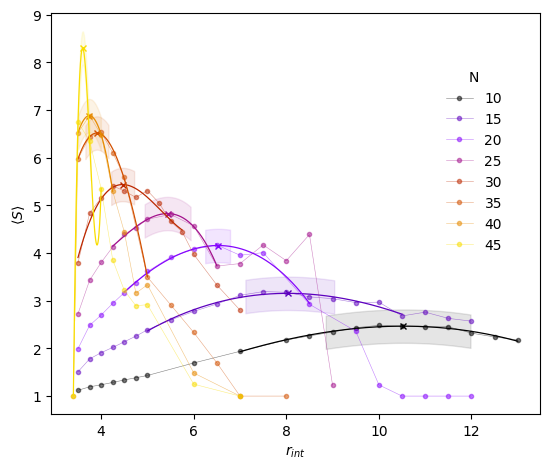

In [7]:
Ns = np.arange(10, 50, 5)
bmxs = [5,5,5,4,3,2,1,1]
amxs = [6,6,3,2,6,3,2,2]
ss = [1,1,1,2,2,1,1,2]

# Ns = [45,]
# bmxs = [1,]
# amxs = [4,]
# ss = [2,]

percs, ebars = meanClusterSize_w_splines_new_kilombo(18.5, Ns, 800, 100000, bmxs, amxs, ss, eps=0.15, eps_shade=0.35)

(array([-0.75728528,  4.11397603]),
 array([[ 0.00085316, -0.00273837],
        [-0.00273837,  0.00898789]]))

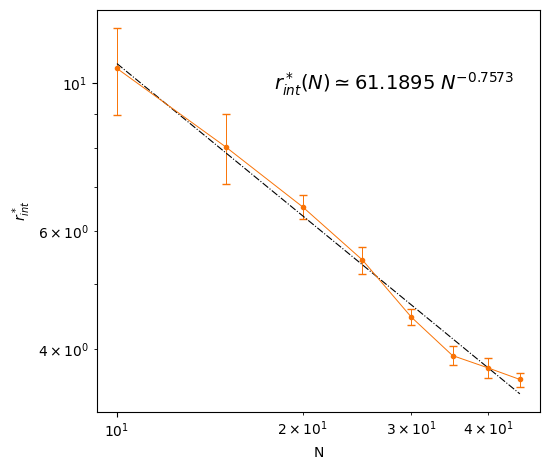

In [8]:
percs_error = [(e[1]-e[0])/2 for e in ebars]

ri_star_N_fit_new_kilombo(ar, Ns, loops, 100000, percs, err_percs_from_spline=percs_error, use_sigma=False)

In [11]:
# get maximums from actual data, without interpolation
Ns = np.arange(10,50,5)
percs, errs = [], []
for N in Ns:
    dfmcs = pd.read_csv(f'{getConfigsPath()}/processed_data/meanClusterSize_N_{N}_ar_{ar}_ir_loops_{loops}.csv')
    maxMCS = max(dfmcs['mcs'])
    i = dfmcs[dfmcs.mcs == maxMCS].index[0]
    perc_r = dfmcs.iloc[i]['interac_r']
    ebars_perc_r = ((perc_r-dfmcs.iloc[i-1]['interac_r'])/2, (dfmcs.iloc[i+1]['interac_r']-perc_r)/2)
    percs.append(perc_r), errs.append(ebars_perc_r)


Text(0.4, 0.8, '$r_{int}^*(N) \\simeq 49.5473 \\; N^{-0.7018}$')

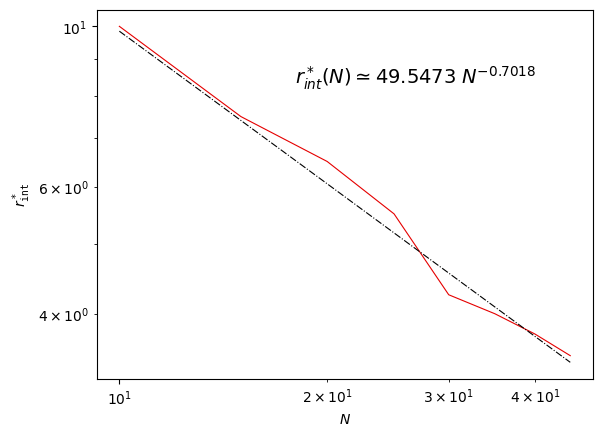

In [13]:
from scipy.optimize import curve_fit
fig, ax = plt.subplots()
ax.set(xlabel='$N$', ylabel=r'$r_{\tt int}^*$', xscale='log', yscale='log')
# ax.errorbar(Ns, percs, np.array(errs).T, lw=0.8, elinewidth=0.8, capsize=3.0, color='xkcd:red')
ax.plot(Ns, percs, lw=0.8, color='xkcd:red')
percs_error = [(e[1]+e[0])/2 for e in errs]
paramfit, covfit = curve_fit(linFunc, np.log(Ns), np.log(percs), sigma = percs_error)
# transform the parameters to those of the power law
const = np.exp(paramfit[1])
exponent = paramfit[0]
fit = powerLaw(np.array(Ns), const, exponent)
ax.plot(Ns, fit, ls='-.', lw=0.8, color='k')
ax.text(0.4,0.8, fr'$r_{{int}}^*(N) \simeq {round(const,4)} \; N^{{{round(exponent,4)}}}$', transform=ax.transAxes, fontsize=14)